In [1]:
import numpy as np
import pandas as pd
from numpy.random import randn
import matplotlib.pyplot as plt
from kf_book.book_plots import plot_measurements
from kf_book.book_plots import plot_filter
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

In [2]:
class PosSensor(object):
    def __init__(self, pos = (0, 0), vel = (0, 0), noise_std = 1):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
    
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]
    

(<matplotlib.collections.PathCollection at 0x17beacbe5c8>,)

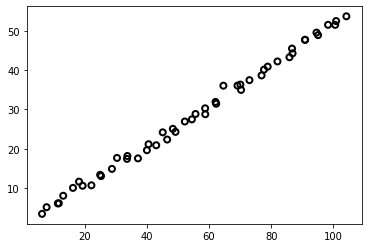

In [3]:
pos , vel = (4, 3), (2, 1)
sensor = PosSensor(pos, vel, noise_std = 1)
ps = np.array([sensor.read() for _ in range(50)])
plot_measurements(ps[:,0], ps[:,1])

## Design State Transition Function

\begin{align}
x &= 1 * x + \Delta t*\dot{x} + 0 * y + 0 * \dot{y} \\
V_{x} &= 0 * x + 1 * \dot{x} + 0 * y + 0 * \dot{y} \\
y &= 0 * x + 0*\dot{x} + 1 * y + \Delta t * \dot{y} \\
V_{y} &= 0 * x + 0 * \dot{x} + 0 * y + 1 * \dot{y} \\
\end{align}
$$
\begin{bmatrix} 
x \\ 
V_{x} \\ 
y \\ 
V_{y} \end{bmatrix} = 
\begin{bmatrix}1 & \Delta t & 0 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & 1 & \Delta t \\ 
0 & 0 & 0 & 1 
\end{bmatrix} \times
\begin{bmatrix} 
x \\ 
\dot{x} \\ 
y \\ 
\dot{y} \end{bmatrix}
$$

In [5]:
tracker = KalmanFilter(dim_x = 4, dim_z = 2)
dt = 1
tracker.F = np.array([[1, dt, 0, 0],
                      [0,  1, 0, 0],
                      [0,  0, 1, dt],
                      [0,  0, 0, 1]])

## Design the Process Noise Matrix

In [6]:
q = Q_discrete_white_noise(dim = 2, dt = dt, var = 0.001)
tracker.Q =  block_diag(q, q)
print(tracker.Q)

[[0.00025 0.0005  0.      0.     ]
 [0.0005  0.001   0.      0.     ]
 [0.      0.      0.00025 0.0005 ]
 [0.      0.      0.0005  0.001  ]]


# Design the Measurement Function

In [7]:
tracker.H = np.array([[1/0.3048, 0, 0, 0],
                      [0, 0, 1/0.3048, 0]])

# Design the Measurement Noise Matrix

In [9]:
tracker.R = np.array([[5.0, 0.0],
                      [0.0, 5.0]])

In [10]:
tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500

In [11]:
R_std = 0.35
Q_std = 0.04
def tracker1():
    tracker = KalmanFilter(dim_x = 4, dim_z = 2)
    dt = 1.0
    tracker.F = np.array([[1, dt, 0, 0],
                      [0,  1, 0, 0],
                      [0,  0, 1, dt],
                      [0,  0, 0, 1]])
    
    tracker.u = 0.0
    
    tracker.H = np.array([[1/0.3048, 0, 0, 0],
                          [0, 0, 1/0.3048, 0]])
    
    tracker.R = np.eye(2) * R_std ** 2
    q = Q_discrete_white_noise(dim = 2, dt = dt, var = 0.001)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0]]).T
    tracker.P = np.eye(4) * 500
    return tracker
N = 30

sensor = PosSensor((0,0), (2, 0.2), noise_std = R_std)


In [13]:
zs = np.array([sensor.read() for _ in range(N)])
print(np.shape(zs))

(30, 2)


<font size="5"></font>
$$\huge \begin{align}
f_{x} &= v\Delta t = 15 \times 2 \\
\bar{x}_{k} &= 10 + (15 \times 2) = 40
\end{align}$$
\
#